In [21]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors

%matplotlib inline

In [2]:
from tensorflow.keras import backend as K
import sys

In [3]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params (None,19,19,5,85)
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])


    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # obtain the height and width 
 
    # con_height_index=[0...18]- tensor
    conv_height_index = K.arange(0, stop=conv_dims[0])
    
    # con_width_index=[0...18]- tensor
    conv_width_index = K.arange(0, stop=conv_dims[1])
    
    #tile 
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])


    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))



    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs


In [4]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    ### START CODE HERE
    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = np.multiply(box_confidence,box_class_probs)

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    # IMPORTANT: set axis to -1
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    #box_class_scores of shape (19,19,5)
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = np.where(box_class_scores>=threshold,True,False)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes =tf.boolean_mask(box_classes,filtering_mask)
    ### END CODE HERE
    
    return scores, boxes, classes

In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    ### START CODE HERE
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_output_size=max_boxes_tensor, iou_threshold=iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    ### END CODE HERE

    
    return scores, boxes, classes

In [6]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [7]:

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy,box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes,iou_threshold)
    ### END CODE HERE
    
    return scores, boxes, classes

### Define anchors, class_names and target size of the image

In [16]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size
#new_folder="crop/"


In [9]:
def retrieve_index_from_classname(name):
    return class_names.index(name)
retrieve_index_from_classname('cat')

15

In [23]:
import imghdr
import colorsys
import random
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)[:,:,:,0:3]  # Add batch dimension.
    return image, image_data

### Utils functions to read from the output into real boxes and classes

In [24]:
def predict(image_folder,new_folder):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image from a folder
    files=os.listdir(image_folder)
    
    for fname in files:
        image, image_data = preprocess_image(os.path.join(image_folder,fname), model_image_size = (608, 608))
        yolo_model_outputs = yolo_model(image_data)
        yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
        out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
        
       
        image_path=os.path.join(image_folder,fname)
        print(image_path)
        out_classes,out_boxes=filter_cat(out_boxes,out_classes)
        crop_img(image_path, out_boxes, out_classes, new_folder)
       




In [19]:
# a function to filter the result of yolo_eval, only pass boxes that are classified as "cat"
def filter_cat(out_boxes,out_classes):
    index=retrieve_index_from_classname('cat')
    filter_mask=np.where(out_classes==index,True,False)
    cat_classes=tf.boolean_mask(out_classes,filter_mask)
    cat_boxes=tf.boolean_mask(out_boxes,filter_mask)
    return cat_classes,cat_boxes
    
    


In [25]:
def crop_img(img_path, boxes, box_classes, new_folder):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    #image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))
        
    img=Image.open(img_path)
    img_name=os.path.basename(img_path)
    img_name,img_extension=img_name.split('.')
    
    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(img.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(img.size[0], np.floor(right + 0.5).astype('int32'))
        
        new_crop=img.crop((left,top,right,bottom))
        crop_name=img_name+f'{i}'+"."+img_extension
        new_crop.save(os.path.join(new_folder,crop_name))
        
        

        


### Load model

In [13]:
yolo_model = load_model("model_data/", compile=False)

In [37]:
img_folder="cats_and_dogs/"
crop_folder='crop/'
subs=os.listdir('cats_and_dogs/')
for sub in subs:
    sub_dir=os.path.join(img_folder,sub)
    #create a folder in crop with the same name
    os.makedirs(os.path.join(crop_folder,sub),exist_ok=True)
    crop_dir=os.path.join(crop_folder,sub)
    predict(sub_dir,crop_dir)
    

C:\Users\NET-025\AppData\Local\Temp\ipykernel_11384\425310734.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)


cats_and_dogs/four\01.jpg
cats_and_dogs/four\02.jpg
cats_and_dogs/four\03.jpg
cats_and_dogs/four\04.jpg
cats_and_dogs/four\05.jpg
cats_and_dogs/four\06.jpg
cats_and_dogs/four\07.jpg
cats_and_dogs/four\08.jpg
cats_and_dogs/four\09.jpg
cats_and_dogs/four\10.jpg
cats_and_dogs/four\11.jpg
cats_and_dogs/four\12.jpg
cats_and_dogs/four\13.jpg
cats_and_dogs/four\14.jpg
cats_and_dogs/four\15.jpg
cats_and_dogs/four\16.jpg
cats_and_dogs/four\17.jpg
cats_and_dogs/four\18.jpg
cats_and_dogs/one\Screenshot (10).png
cats_and_dogs/one\Screenshot (11).png
cats_and_dogs/one\Screenshot (12).png
cats_and_dogs/one\Screenshot (13).png
cats_and_dogs/one\Screenshot (14).png
cats_and_dogs/one\Screenshot (15).png
cats_and_dogs/one\Screenshot (16).png
cats_and_dogs/one\Screenshot (17).png
cats_and_dogs/one\Screenshot (18).png
cats_and_dogs/one\Screenshot (19).png
cats_and_dogs/one\Screenshot (2).png
cats_and_dogs/one\Screenshot (20).png
cats_and_dogs/one\Screenshot (21).png
cats_and_dogs/one\Screenshot (22).png
c

In [36]:
crop_dir

In [26]:

predict('cats_and_dogs/one','crop/')

C:\Users\NET-025\AppData\Local\Temp\ipykernel_11384\425310734.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)


cats_and_dogs/one\Screenshot (10).png
cats_and_dogs/one\Screenshot (11).png
cats_and_dogs/one\Screenshot (12).png
cats_and_dogs/one\Screenshot (13).png
cats_and_dogs/one\Screenshot (14).png
cats_and_dogs/one\Screenshot (15).png
cats_and_dogs/one\Screenshot (16).png
cats_and_dogs/one\Screenshot (17).png
cats_and_dogs/one\Screenshot (18).png
cats_and_dogs/one\Screenshot (19).png
cats_and_dogs/one\Screenshot (2).png
cats_and_dogs/one\Screenshot (20).png
cats_and_dogs/one\Screenshot (21).png
cats_and_dogs/one\Screenshot (22).png
cats_and_dogs/one\Screenshot (23).png
cats_and_dogs/one\Screenshot (3).png
cats_and_dogs/one\Screenshot (4).png
cats_and_dogs/one\Screenshot (5).png
cats_and_dogs/one\Screenshot (6).png
cats_and_dogs/one\Screenshot (7).png
cats_and_dogs/one\Screenshot (8).png
cats_and_dogs/one\Screenshot (9).png


In [29]:
test=Image.open("D:\Yolo\Files\home\jovyan\work\W3A1\cats_and_dogs\Screenshot (2).png")

In [30]:
test.size

(1920, 1080)

In [64]:
import imghdr
import colorsys
import random
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)[:,:,:,0:3]  # Add batch dimension.
    return image, image_data

In [60]:
test,np_test=preprocess_image("D:\Yolo\Files\home\jovyan\work\W3A1\cats_and_dogs\Screenshot (23).png",(608,608))

C:\Users\NET-025\AppData\Local\Temp\ipykernel_9776\425310734.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)


array([[[[0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         ...,
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ]],

        [[0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         ...,
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ]],

        [[0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         ...,
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ],
         [0.87058824, 0.88235295, 0.9019608 ]],

        ...,

        [[0.13333334, 0.13725491, 0.10588235],
         [0.13333334, 0.13725491, 0.10588235]

In [62]:
 PIL_image = Image.fromarray(np.uint8(np_test)).convert('RGB')

TypeError: Cannot handle this data type: (1, 1, 608, 3), |u1

TypeError: Invalid shape (1, 608, 608, 3) for image data

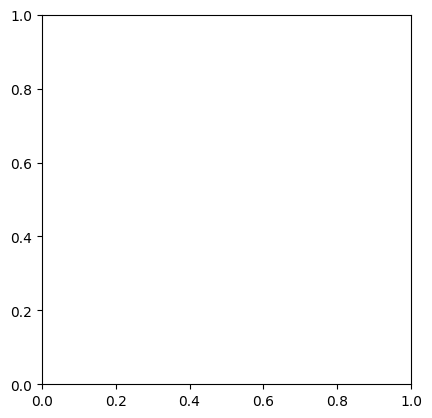